In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List
import copy

In [44]:
hvac_features = pd.read_csv("../data/client1_hvac.csv")
solar_features = pd.read_csv("../data/client2_solar.csv")
solar_for_hvac = pd.read_csv("../data/labels.csv")

print("Client 1 (HVAC) features:\n", hvac_features.head())
print("\nClient 2 (Solar) features:\n", solar_features.head())
print("\nServer labels (design target):\n", solar_for_hvac.head())

Client 1 (HVAC) features:
     avg_temp  energy_consumed  run_hours  cooling_setpoint  heating_setpoint
0  21.872701         7.776994   7.570234         23.018109         20.287984
1  24.753572        13.128514   7.481873         23.390044         21.221729
2  23.659970        18.094188  11.437527         21.751404         21.040644
3  22.993292        15.983373   7.497277         22.874622         18.615600
4  20.780093        17.098417   7.631698         22.715238         18.596998

Client 2 (Solar) features:
    solar_gen  battery_charge  battery_discharge  grid_draw        soc
0   5.904533       58.895417           1.939973   7.202679  83.086241
1   7.101535       30.343182           9.338626   6.872830  52.028839
2  12.818211       72.343674          41.562290   0.957542  67.992822
3   5.100066       56.786974          38.338418   9.225724  44.883864
4  13.044745       29.432233          17.532135   5.684722  60.402766

Server labels (design target):
    solar_for_hvac
0        4.

In [45]:
class FeatureEncoder(nn.Module):
    """Neural network encoder for client features"""
    
    def __init__(self, input_dim: int, hidden_dims: List[int], output_dim: int):
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        layers.append(nn.Tanh())  # Bounded output for better alignment
        
        self.encoder = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.encoder(x)

In [46]:
class ServerClassifier(nn.Module):
    """Server-side classifier and alignment model"""
    
    def __init__(self, encoding_dim: int, hidden_dims: List[int], output_dim: int):
        super().__init__()
        
        # Alignment layers - maps both client encodings to common space
        self.align_client1 = nn.Linear(encoding_dim, encoding_dim)
        self.align_client2 = nn.Linear(encoding_dim, encoding_dim)
        
        # Classifier
        classifier_input = encoding_dim * 2  # Concatenated aligned representations
        layers = []
        prev_dim = classifier_input
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.classifier = nn.Sequential(*layers)
        
    def align_representations(self, z1, z2):
        """Align representations from both clients"""
        z1_aligned = torch.tanh(self.align_client1(z1))
        z2_aligned = torch.tanh(self.align_client2(z2))
        return z1_aligned, z2_aligned
    
    def forward(self, z1, z2):
        z1_aligned, z2_aligned = self.align_representations(z1, z2)
        # Concatenate aligned representations
        combined = torch.cat([z1_aligned, z2_aligned], dim=1)
        return self.classifier(combined)

In [47]:
class PrivacyMask:
    """Privacy-preserving masking for client representations"""
    
    def __init__(self, noise_level: float = 0.1, quantization_levels: int = 256):
        self.noise_level = noise_level
        self.quantization_levels = quantization_levels
        
    def apply_masking(self, representations: torch.Tensor) -> torch.Tensor:
        """Apply multiple privacy-preserving transformations"""
        masked = representations.clone()
        
        # 1. Add Gaussian noise
        noise = torch.normal(0, self.noise_level, masked.shape)
        masked = masked + noise
        
        # 2. Quantization
        min_val, max_val = masked.min(), masked.max()
        normalized = (masked - min_val) / (max_val - min_val + 1e-8)
        quantized = torch.round(normalized * (self.quantization_levels - 1))
        masked = quantized / (self.quantization_levels - 1) * (max_val - min_val) + min_val
        
        # 3. Random orthogonal transformation (simplified)
        rotation_matrix = torch.randn(masked.shape[1], masked.shape[1])
        rotation_matrix = torch.qr(rotation_matrix)[0]  # Orthogonal matrix
        masked = torch.mm(masked, rotation_matrix)
        
        return masked

In [48]:
class FedCVTClient:
    """Federated client for HVAC or Solar data"""
    
    def __init__(self, client_id: str, input_dim: int, encoding_dim: int, 
                 learning_rate: float = 0.001):
        self.client_id = client_id
        self.encoder = FeatureEncoder(
            input_dim=input_dim,
            hidden_dims=[64, 32],
            output_dim=encoding_dim
        )
        self.optimizer = optim.Adam(self.encoder.parameters(), lr=learning_rate)
        self.privacy_mask = PrivacyMask(noise_level=0.1)
        self.scaler = StandardScaler()
        
    def preprocess_data(self, data: np.ndarray, fit_scaler: bool = False) -> torch.Tensor:
        """Preprocess client data"""
        if fit_scaler:
            self.scaler.fit(data)
        
        normalized_data = self.scaler.transform(data)
        return torch.FloatTensor(normalized_data)
    
    def encode_data(self, data: torch.Tensor) -> torch.Tensor:
        """Encode client data"""
        self.encoder.eval()
        with torch.no_grad():
            encoded = self.encoder(data)
        return encoded
    
    def send_encoded_data(self, data: torch.Tensor) -> torch.Tensor:
        """Encode and mask data for server transmission"""
        encoded = self.encode_data(data)
        masked = self.privacy_mask.apply_masking(encoded)
        return masked
    
    def update_encoder(self, gradients: torch.Tensor, encoded_data: torch.Tensor):
        """Update encoder based on gradients from server"""
        self.encoder.train()
        self.optimizer.zero_grad()
        
        # Compute pseudo-loss using received gradients
        # This simulates backpropagation from server
        encoded = self.encoder(self.current_batch)
        pseudo_loss = torch.sum(encoded * gradients)
        
        pseudo_loss.backward()
        self.optimizer.step()
    
    def local_training_step(self, data: torch.Tensor):
        """Store current batch for gradient computation"""
        self.current_batch = data


In [49]:

class FedCVTServer:
    """Federated server coordinating HVAC and Solar clients"""
    
    def __init__(self, encoding_dim: int, learning_rate: float = 0.001):
        self.classifier = ServerClassifier(
            encoding_dim=encoding_dim,
            hidden_dims=[128, 64, 32],
            output_dim=1  # Regression for solar_for_hvac
        )
        self.optimizer = optim.Adam(self.classifier.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        
    def train_step(self, z1_masked: torch.Tensor, z2_masked: torch.Tensor, 
                   labels: torch.Tensor) -> float:
        """Single training step on server"""
        self.classifier.train()
        self.optimizer.zero_grad()
        
        # Forward pass
        predictions = self.classifier(z1_masked, z2_masked)
        loss = self.criterion(predictions.squeeze(), labels)
        
        # Backward pass
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def compute_client_gradients(self, z1_masked: torch.Tensor, z2_masked: torch.Tensor, 
                                labels: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Compute gradients w.r.t. client representations"""
        z1_masked.requires_grad_(True)
        z2_masked.requires_grad_(True)
        
        predictions = self.classifier(z1_masked, z2_masked)
        loss = self.criterion(predictions.squeeze(), labels)
        
        # Compute gradients w.r.t. masked representations
        grad_z1 = torch.autograd.grad(loss, z1_masked, retain_graph=True)[0]
        grad_z2 = torch.autograd.grad(loss, z2_masked, retain_graph=False)[0]
        
        return grad_z1.detach(), grad_z2.detach()


In [50]:

class FedCVTTrainer:
    """Main training coordinator for FedCVT"""
    
    def __init__(self, encoding_dim: int = 16):
        self.encoding_dim = encoding_dim
        
        # Initialize clients
        self.hvac_client = FedCVTClient("HVAC", input_dim=5, encoding_dim=encoding_dim)
        self.solar_client = FedCVTClient("Solar", input_dim=5, encoding_dim=encoding_dim)
        
        # Initialize server
        self.server = FedCVTServer(encoding_dim=encoding_dim)
        
        # Training history
        self.history = {
            'round_losses': [],
            'communication_rounds': []
        }
    
    def train(self, hvac_data: np.ndarray, solar_data: np.ndarray, labels: np.ndarray,
              num_rounds: int = 50, server_epochs: int = 10, batch_size: int = 64):
        """Train FedCVT model using Approach 2 (Periodic Communication)"""
        
    # Preprocess data
        hvac_tensor = self.hvac_client.preprocess_data(hvac_data, fit_scaler=True)
        solar_tensor = self.solar_client.preprocess_data(solar_data, fit_scaler=True)
        labels_tensor = torch.FloatTensor(labels.values).view(-1)   # ✅ FIX HERE
    
    # Create data loaders
        dataset_size = len(hvac_tensor)
        num_batches = (dataset_size + batch_size - 1) // batch_size
        
        print("Starting FedCVT Training...")
        print(f"Dataset size: {dataset_size}, Batch size: {batch_size}, Batches per round: {num_batches}")
        
        for round_num in range(num_rounds):
            round_losses = []
            
            # === PHASE 1: CLIENTS ENCODE AND SEND ALL DATA ===
            print(f"\nRound {round_num + 1}/{num_rounds}")
            
            all_z1_masked = []
            all_z2_masked = []
            all_labels = []
            
            # Process all batches and collect encoded data
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, dataset_size)
                
                hvac_batch = hvac_tensor[start_idx:end_idx]
                solar_batch = solar_tensor[start_idx:end_idx]
                labels_batch = labels_tensor[start_idx:end_idx]
                
                # Clients encode and mask their data
                z1_masked = self.hvac_client.send_encoded_data(hvac_batch)
                z2_masked = self.solar_client.send_encoded_data(solar_batch)
                
                all_z1_masked.append(z1_masked)
                all_z2_masked.append(z2_masked)
                all_labels.append(labels_batch)
            
            # === PHASE 2: SERVER TRAINS FOR MULTIPLE EPOCHS ===
            print(f"  Server training for {server_epochs} epochs...")
            
            for epoch in range(server_epochs):
                epoch_losses = []
                
                for batch_idx in range(num_batches):
                    z1_batch = all_z1_masked[batch_idx]
                    z2_batch = all_z2_masked[batch_idx]
                    labels_batch = all_labels[batch_idx]
                    
                    # Server training step
                    loss = self.server.train_step(z1_batch, z2_batch, labels_batch)
                    epoch_losses.append(loss)
                
                avg_epoch_loss = np.mean(epoch_losses)
                if epoch % 5 == 0:
                    print(f"    Epoch {epoch+1}: Loss = {avg_epoch_loss:.4f}")
            
            # === PHASE 3: COMPUTE CLIENT GRADIENTS ===
            print("  Computing gradients for clients...")
            
            all_grads_z1 = []
            all_grads_z2 = []
            
            for batch_idx in range(num_batches):
                z1_batch = all_z1_masked[batch_idx]
                z2_batch = all_z2_masked[batch_idx] 
                labels_batch = all_labels[batch_idx]
                
                grad_z1, grad_z2 = self.server.compute_client_gradients(
                    z1_batch, z2_batch, labels_batch
                )
                all_grads_z1.append(grad_z1)
                all_grads_z2.append(grad_z2)
            
            # === PHASE 4: CLIENTS UPDATE ENCODERS ===
            print("  Clients updating encoders...")
            
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, dataset_size)
                
                hvac_batch = hvac_tensor[start_idx:end_idx]
                solar_batch = solar_tensor[start_idx:end_idx]
                
                # Store current batch for gradient computation
                self.hvac_client.local_training_step(hvac_batch)
                self.solar_client.local_training_step(solar_batch)
                
                # Update encoders with received gradients
                self.hvac_client.update_encoder(all_grads_z1[batch_idx], hvac_batch)
                self.solar_client.update_encoder(all_grads_z2[batch_idx], solar_batch)
            
            # Record round statistics
            round_avg_loss = np.mean([loss for losses in [self.evaluate_round(hvac_tensor, solar_tensor, labels_tensor)] for loss in losses])
            self.history['round_losses'].append(round_avg_loss)
            self.history['communication_rounds'].append(round_num + 1)
            
            print(f"  Round {round_num + 1} completed. Average loss: {round_avg_loss:.4f}")
        
        print("\nTraining completed!")
    
    def evaluate_round(self, hvac_data: torch.Tensor, solar_data: torch.Tensor, 
                      labels: torch.Tensor) -> List[float]:
        """Evaluate current round performance"""
        self.server.classifier.eval()
        
        with torch.no_grad():
            z1 = self.hvac_client.encode_data(hvac_data)
            z2 = self.solar_client.encode_data(solar_data)
            z1_masked = self.hvac_client.privacy_mask.apply_masking(z1)
            z2_masked = self.solar_client.privacy_mask.apply_masking(z2)
            
            predictions = self.server.classifier(z1_masked, z2_masked)
            loss = self.server.criterion(predictions.squeeze(), labels)
            
            return [loss.item()]
    
    def predict(self, hvac_data: np.ndarray, solar_data: np.ndarray) -> np.ndarray:
        """Make predictions using trained model"""
        hvac_tensor = self.hvac_client.preprocess_data(hvac_data)
        solar_tensor = self.solar_client.preprocess_data(solar_data)
        
        self.server.classifier.eval()
        with torch.no_grad():
            z1 = self.hvac_client.encode_data(hvac_tensor)
            z2 = self.solar_client.encode_data(solar_tensor)
            z1_masked = self.hvac_client.privacy_mask.apply_masking(z1)
            z2_masked = self.solar_client.privacy_mask.apply_masking(z2)
            
            predictions = self.server.classifier(z1_masked, z2_masked)
            return predictions.squeeze().numpy()
    
    def plot_training_history(self):
        """Plot training progress"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['communication_rounds'], self.history['round_losses'], 
                'b-o', linewidth=2, markersize=6)
        plt.xlabel('Communication Round')
        plt.ylabel('Average Loss')
        plt.title('FedCVT Training Progress')
        plt.grid(True, alpha=0.3)
        plt.show()


In [51]:
from sklearn.model_selection import train_test_split
import numpy as np

def main():
    """Main execution function"""
    print("Generating synthetic HVAC and Solar dataset...")

    # Use the provided datasets (already given)
    # hvac_features, solar_features, solar_for_hvac are pandas DataFrames

    print(f"HVAC features shape: {hvac_features.shape}")
    print(f"Solar features shape: {solar_features.shape}")  
    print(f"Labels shape: {solar_for_hvac.shape}")
    
    # Split indices for training and testing
    indices = np.arange(len(hvac_features))
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

    # Split features and labels
    hvac_train, hvac_test = hvac_features.iloc[train_idx], hvac_features.iloc[test_idx]
    solar_train, solar_test = solar_features.iloc[train_idx], solar_features.iloc[test_idx]
    labels_train, labels_test = solar_for_hvac.iloc[train_idx], solar_for_hvac.iloc[test_idx]

    # Initialize and train FedCVT model
    print("\nInitializing FedCVT model...")
    fedcvt = FedCVTTrainer(encoding_dim=16)
    
    # Train the model using Approach 2 (Periodic Communication)
    fedcvt.train(
        hvac_data=hvac_train,
        solar_data=solar_train, 
        labels=labels_train,
        num_rounds=30,           # Number of communication rounds
        server_epochs=8,         # Server trains for 8 epochs per round
        batch_size=64
    )
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    predictions = fedcvt.predict(hvac_test, solar_test).flatten()
    
    # Calculate test metrics
    # Calculate test metrics
    labels_test_array = labels_test.values.flatten()
    mse = np.mean((predictions - labels_test_array) ** 2)
    mae = np.mean(np.abs(predictions - labels_test_array))
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")

# Plot training progress
    fedcvt.plot_training_history()

# Show some predictions vs actual
    print("\nSample predictions vs actual:")
    for i in range(min(10, len(predictions))):
        print(f"Predicted: {predictions[i]:.2f}, Actual: {labels_test_array[i]:.2f}")


Generating synthetic HVAC and Solar dataset...
HVAC features shape: (1000, 5)
Solar features shape: (1000, 5)
Labels shape: (1000, 1)

Initializing FedCVT model...
Starting FedCVT Training...
Dataset size: 800, Batch size: 64, Batches per round: 13

Round 1/30
  Server training for 8 epochs...
    Epoch 1: Loss = 81.0268
    Epoch 6: Loss = 75.1997
  Computing gradients for clients...
  Clients updating encoders...
  Round 1 completed. Average loss: 85.4026

Round 2/30
  Server training for 8 epochs...
    Epoch 1: Loss = 71.3029
    Epoch 6: Loss = 59.0610
  Computing gradients for clients...
  Clients updating encoders...
  Round 2 completed. Average loss: 59.0279

Round 3/30
  Server training for 8 epochs...
    Epoch 1: Loss = 51.3267
    Epoch 6: Loss = 31.2170
  Computing gradients for clients...
  Clients updating encoders...
  Round 3 completed. Average loss: 22.6412

Round 4/30
  Server training for 8 epochs...
    Epoch 1: Loss = 26.1245
    Epoch 6: Loss = 14.7598
  Computin

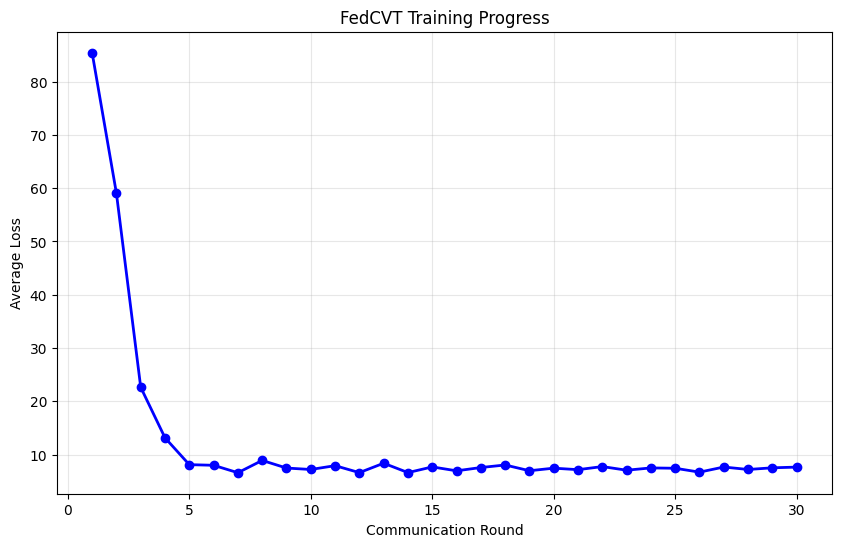


Sample predictions vs actual:
Predicted: 8.36, Actual: 13.05
Predicted: 8.06, Actual: 4.02
Predicted: 8.26, Actual: 14.33
Predicted: 8.22, Actual: 7.43
Predicted: 7.94, Actual: 7.27
Predicted: 9.25, Actual: 4.75
Predicted: 9.55, Actual: 5.65
Predicted: 8.20, Actual: 6.08
Predicted: 8.77, Actual: 12.07
Predicted: 8.94, Actual: 10.05


In [52]:
if __name__ == "__main__":
    main()